In [1]:
from io import BytesIO
from zipfile import ZipFile
import requests
import geopandas as gpd
%matplotlib inline

In [2]:
sublette_url = 'https://wgfd.wyo.gov/WGFD/media/content/Wildlife/Geospatial/Big%20Game/MuleDeerMigrationCorridorComplex(Sublette).zip'
r = requests.get(sublette_url)
z = ZipFile(BytesIO(r.content))
available_shp_files = [y for y in sorted(z.namelist()) for ending in ['shp'] if y.endswith(ending)]
z.extractall('data/')

In [3]:
print (available_shp_files)

['MuleDeerMigrationCorridorBottlenecksSublette.shp', 'MuleDeerMigrationCorridorStopoversSublette.shp', 'MuleDeerMigrationCorridorsSublette.shp']


In [4]:
deer_sublette_corridors = gpd.read_file('data/MuleDeerMigrationCorridorsSublette.shp')
deer_sublette_bottleneck = gpd.read_file('data/MuleDeerMigrationCorridorBottlenecksSublette.shp')

In [5]:
mdeer_sublette_corridors = deer_sublette_corridors.to_crs({'init':'epsg:4326'})
mdeer_sublette_bottlenecks = deer_sublette_bottleneck.to_crs({'init':'epsg:4326'})
mdeer_sublette_bottlenecks

,Acres,HERDNAME,Name,Shape_Area,Shape_Leng,geometry
0,560.36,Sublette,Fremont Lake,2.266245e+06,6789.687823,"POLYGON ((-109.837842064998 42.90646480341124,..."
1,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,POLYGON ((-109.9088392644179 42.99733013827631...
2,769.72,Sublette,Boulder Lake,3.112841e+06,9890.372406,POLYGON ((-109.7050102016812 42.83601307042731...
3,772.69,Sublette,New Fork Lake,3.125140e+06,10032.345444,"POLYGON ((-109.969197527838 43.08347192551762,..."
4,125.62,Sublette,Duck Creek,5.080774e+05,2527.003269,POLYGON ((-109.9521529570858 42.87273599212016...
5,362.84,Sublette,Trapper's Point,1.467520e+06,6314.822461,POLYGON ((-109.9939060678623 42.88280430173704...
6,484.45,Sublette,Daniel,1.959432e+06,8347.139414,POLYGON ((-110.0768054258186 42.90155805649331...


In [6]:
#downloaded padus from ScienceBase and reprojected it to WGS84 in ESRI.  When doing that in GC2 and in Python the reprojection showed that it worked but failed to do anything
wy_padus = gpd.read_file('pad/wy_padus1_4com_wgs84.shp')

In [7]:
wy_padus.crs = {'init': 'epsg:4326'}

In [8]:
wy_padus.columns

Index(['Access', 'Access_Src', 'Agg_Src', 'Category', 'Comments', 'Date_Est',
       'Des_Tp', 'FeatureID', 'GAPCdDt', 'GAPCdSrc', 'GAP_Sts', 'GIS_Acres',
       'GIS_Src', 'IUCNCtDt', 'IUCNCtSrc', 'IUCN_Cat', 'Loc_Ds', 'Loc_Mang',
       'Loc_Nm', 'Loc_Own', 'Mang_Name', 'Mang_Type', 'Own_Name', 'Own_Type',
       'Source_PAI', 'Src_Date', 'State_Nm', 'Unit_Nm', 'WDPA_Cd', 'd_Access',
       'd_Category', 'd_Des_Tp', 'd_GAP_Sts', 'd_IUCN_Cat', 'd_Mang_Nam',
       'd_Mang_Typ', 'd_Own_Name', 'd_Own_Type', 'd_State_Nm', 'geometry'],
      dtype='object')

In [9]:
#Remove some unneeded fields from PADUS
remove_fields = ['Comments','Loc_Ds', 'GAPCdDt', 'GAP_Sts', 'GAPCdSrc', 'Des_Tp', 'Date_Est', 'Loc_Mang', 'Loc_Nm', 'Loc_Own', 'Mang_Name', 'Mang_Type', 'Own_Name', 'Own_Type', 'GIS_Acres', 'GIS_Src', 'IUCN_Cat', 'IUCNCtDt', 'IUCNCtSrc', 'Source_PAI', 'Src_Date', 'State_Nm', 'WDPA_Cd']
for field in remove_fields:
    del wy_padus[field]
    
wy_padus.columns

Index(['Access', 'Access_Src', 'Agg_Src', 'Category', 'FeatureID', 'Unit_Nm',
       'd_Access', 'd_Category', 'd_Des_Tp', 'd_GAP_Sts', 'd_IUCN_Cat',
       'd_Mang_Nam', 'd_Mang_Typ', 'd_Own_Name', 'd_Own_Type', 'd_State_Nm',
       'geometry'],
      dtype='object')

In [10]:
#this simple code was way to slow
#sublette_pad_intersect= gpd.overlay(wy_mdeer_sublette, padus_wy, how='intersection')

#selects only those intersected polygons and builds list of intersecting polygons
padus_sublette = []
for index, orig in wy_padus.iterrows():
    for index2, ref in mdeer_sublette_corridors.iterrows():      
        if ref['geometry'].intersects(orig['geometry']):
            pad_id =orig['FeatureID']
            padus_sublette.append({'geometry':ref['geometry'].intersection(orig['geometry']),'pad_id':pad_id})


pad_sublette_inter = gpd.GeoDataFrame(padus_sublette, columns=['geometry','pad_id'], geometry='geometry')
pad_sublette_inter.crs = {'init': 'epsg:4326'}

In [11]:
pad_sublette_inter['diss'] = 1
pad_sublette_inter['geometry']= pad_sublette_inter.buffer(0.0001)
dissolve_intersect = pad_sublette_inter.dissolve(by='diss')

In [50]:
pad_sublette_inter

,geometry,pad_id,diss
0,(POLYGON ((-108.6341027372512 42.3883387601942...,1461,1
1,POLYGON ((-109.8290674387004 42.74309853204439...,1513,1
2,(POLYGON ((-109.0237433374545 42.5210906888089...,1513,1
3,POLYGON ((-108.8375374130402 42.29843012350008...,1532,1
4,(POLYGON ((-108.6340882803965 42.3797427846642...,1532,1
5,(POLYGON ((-109.2855514693989 42.4973502975179...,1532,1
6,POLYGON ((-110.5929254769162 43.07845745748747...,3601,1
7,(POLYGON ((-109.0512796554458 42.5540810987104...,3601,1
8,POLYGON ((-110.2051418280979 43.12603134531398...,3628,1
9,(POLYGON ((-109.0509324344029 42.5543466992339...,5860,1


blue= entire sublette corridor for mule deer


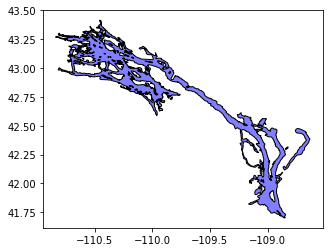

In [12]:
mdeer_sublette_corridors.plot(color='blue')
print ('blue= entire sublette corridor for mule deer')

red= sublette corridor mule deer w/ PAD overlap


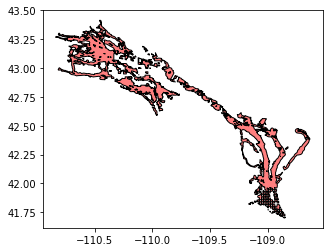

In [13]:
dissolve_intersect.plot(color='red')
print ('red= sublette corridor mule deer w/ PAD overlap')

combined map
blue= sublette corridor mule deer no PAD overlap
red = sublette corridor mule deer w/ PAD overlap


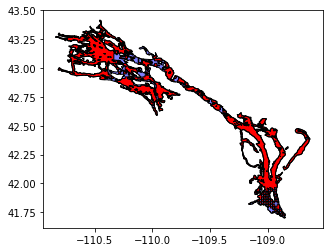

In [14]:
a = mdeer_sublette_corridors.plot(color='blue')
dissolve_intersect.plot(ax=a, color='red', alpha=1)
print ('combined map')
print ('blue= sublette corridor mule deer no PAD overlap')
print ('red = sublette corridor mule deer w/ PAD overlap')

protected areas of the sublette corridor with overlay of bottlenecks


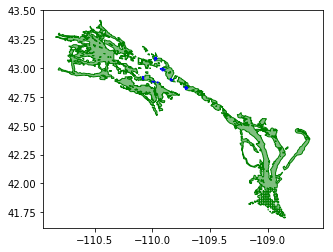

In [33]:
base = dissolve_intersect.plot(color='green',edgecolor='green')
mdeer_sublette_bottlenecks.plot(ax=base, color='blue', edgecolor='blue', markersize=8, alpha = 0.5)
print ('protected areas of the sublette corridor with overlay of bottlenecks')

In [46]:
bottlenecks_no_pad = gpd.overlay(mdeer_sublette_bottlenecks, dissolve_intersect, how='difference')
bottlenecks_w_pad = gpd.overlay(mdeer_sublette_bottlenecks, pad_sublette_inter, how='intersection')

bottlenecks protected in green, bottlenecks not protect in blue


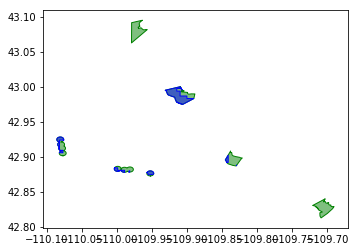

In [41]:
base = mdeer_sublette_bottlenecks.plot(color='green', edgecolor='green')
bottlenecks_no_pad.plot(ax=base, color='blue', edgecolor='blue', markersize=8, alpha = 0.5)
print ('bottlenecks protected in green, bottlenecks not protect in blue')

In [51]:
bottlenecks_w_pad

,Acres,HERDNAME,Name,Shape_Area,Shape_Leng,pad_id,diss,geometry
0,769.72,Sublette,Boulder Lake,3.112841e+06,9890.372406,1513,1,POLYGON ((-109.7050102016812 42.83601307042731...
1,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,1513,1,POLYGON ((-109.9099281485054 42.99036661141931...
2,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,1513,1,POLYGON ((-109.9099281540123 42.99036736345441...
3,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,1513,1,POLYGON ((-109.9099281540123 42.99036736345441...
4,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,1513,1,POLYGON ((-109.9099281266546 42.99036824766857...
5,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,3601,1,POLYGON ((-109.9099281266546 42.99036824766857...
6,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,1513,1,POLYGON ((-109.9098171338592 42.99376831687893...
7,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,1513,1,"POLYGON ((-109.90969971875 42.99746425423183, ..."
8,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,69464,1,"POLYGON ((-109.890299726968 42.98314968035646,..."
9,1212.45,Sublette,Willow Lake,4.903630e+06,11561.125615,69464,1,POLYGON ((-109.8903594324946 42.98314968035258...


In [35]:
sublette_area_alb = mdeer_sublette_corridors.to_crs({'init': 'epsg:5070'})
sublette_area_alb['area_km2']=sublette_area_alb['geometry'].area/10**6

dissolve_intersect.crs = {'init': 'epsg:4326'}
dissolve_intersect_alb = dissolve_intersect.to_crs({'init': 'epsg:5070'})
dissolve_intersect_alb['area_km2']=dissolve_intersect_alb['geometry'].area/10**6

In [36]:
print ('Total area (km2) of sublette corridor: ' + str(int(sublette_area_alb['area_km2'].sum())))
print ('Area (km2) of sublette corridor intersecting protected areas: ' + str(int(dissolve_intersect_alb['area_km2'].sum())))

Total area (km2) of sublette corridor: 3379
Area (km2) of sublette corridor intersecting protected areas: 2768


In [ ]:
### Had coordinate issues with data coming in from here... couldn't successfully reproject and it said 5070 but the other dataset when in 5070 did not line up

### Code that pulled back a subset of PADUS from SFR on GC2 instance
#### Only ran this once and then saved the data local to reduce unneeded load 
#-----------------------------------------------------------------------

#query spatial padus1_4 data for Wyoming from gc2
from bis2 import gc2 
import requests 
import geojson
url = gc2.baseURLs["sqlapi_datadistillery_bcb_beta"] 
table = "padus1_4" 
schema = "sfr" 
limit = 100 
offset = 0 
features = []
query_upid = "%s?q= select _id as id, access, access_src, agg_src, category, d_access, d_category, d_des_tp, d_gap_sts, d_iucn_cat, d_mang_nam, d_mang_typ, d_own_name, d_own_type, d_state_nm, (st_multi(st_makevalid(st_transform(the_geom,4326))))::(MultiPolygon,4326) AS geometry from %s.%s where state_nm='WY' limit %s offset %s" %  (url, schema, table, limit, offset)
page = requests.get(url=query_upid) 
page_json = geojson.loads(page.text) 
features += page_json['features']
while len(page_json['features']) != 0:
    offset += limit
    query_upid = "%s?q= select _id as id, access, access_src, agg_src, category, d_access, d_category, d_des_tp, d_gap_sts, d_iucn_cat, d_mang_nam, d_mang_typ, d_own_name, d_own_type, d_state_nm, (st_multi(st_makevalid(st_transform(the_geom,4326))))::(MultiPolygon,4326) AS geometry from %s.%s where state_nm='WY' limit %s offset %s" % (url, schema, table, limit, offset)
    page = requests.get(url=query_upid)
    page_json = geojson.loads(page.text)
    features += page_json['features']
#Import data into geopandas 
crs = {'init': 'epsg:4362'} 
padus_wy=gpd.GeoDataFrame.from_features(features, crs)
#Save data to geojson file 
padus_wy.to_file( 'padus_wy.geojson', driver='GeoJSON')